In [1]:
import os
import numpy as np
from pandas import read_csv, concat
from tqdm import tqdm

## Section 1: Primary Analysis

#### 1.1 Load and prepare data

In [2]:
## Load behavioral correlates.
data = read_csv(os.path.join('stan_results/coef.csv'))

## Load total scores.
scores = read_csv(os.path.join('data','scores.csv'))

## Load rejection metrics.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Merge DataFrames.
data = data.merge(scores).merge(metrics[['platform','subject','infreq','wsls']])

#### 1.2 Percentile Bootstrap Analysis

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define queries.
queries = [
    'infreq > -1',
    'wsls > 0.106',
    'infreq == 0',
    'wsls > 0.106 and infreq == 0'
]

## Define variables of interest.
rows = ['Intercept', 'prev_outcome', 'prev_trans', 'prev_outcome:prev_trans']
cols = ['mania', 'depression', 'anxiety', 'artistic', 'greed']

## Define number of bootstraps.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
corr = np.zeros(( len(queries), len(rows), len(cols) ))
pval = np.zeros_like(corr)

## Main loop.
for i, query in enumerate(queries):
    
    ## Copy DataFrame.
    df = data.query(query)[rows+cols].copy()
    indices = np.arange(df.shape[0])
    
    ## Compute observed correlations.
    corr[i] = df.corr(method='spearman').loc[rows,cols].values
    
    ## Preallocate space.
    null = np.zeros((n_iter, len(rows), len(cols)))
    
    ## Iteratively compute null distribution.
    for j in tqdm(range(n_iter)):
        
        ## Sample bootstrap sequence.
        ix = np.random.choice(indices, indices.size, replace=True)

        ## Compute bootstrap correlations.
        null[j] = df.iloc[ix].corr(method='spearman').loc[rows,cols].values
        
    ## Compute p-values.
    pval[i] = np.where(np.sign(corr[i]) > 0, null < 0, null > 0).mean(axis=0)

100%|██████████| 5000/5000 [00:09<00:00, 510.17it/s]


## Section 3: Plotting

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#### 3.1 Main Figure

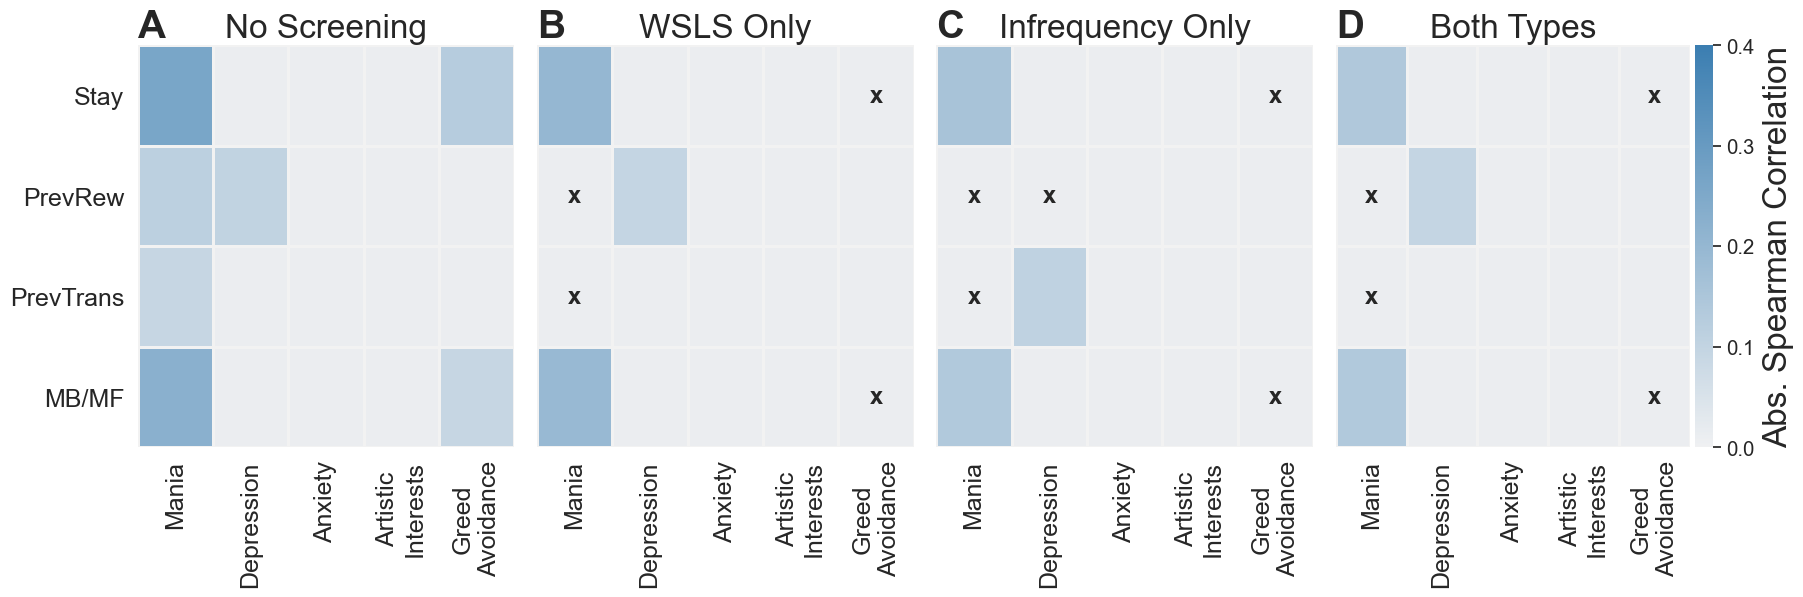

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(18,6))

## Initialize panels.
gs = gridspec.GridSpec(1,4)
gs.update(left=0.075, right=0.95, bottom=0.25, top=0.92, hspace=0, wspace=0.06)

## Define aesthetic features.
cmap = sns.light_palette('#3b7eb1', as_cmap=True)
label_pad = 6

## Define labels.
labels = ['A','B','C','D']
xticklabels = ['Mania', 'Depression', 'Anxiety', 'Artistic\nInterests', 'Greed\nAvoidance']
yticklabels = ['Stay','PrevRew','PrevTrans','MB/MF'] 
titles = ['No Screening', 'WSLS Only', 'Infrequency Only', 'Both Types']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k in range(corr.shape[0]):
    
    ## Initialize axis.
    ax = plt.subplot(gs[k])
    
    ## Define colorbar parameters.
    if k == 3:
        cbar = True
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    else:
        cbar = False
        cbar_ax = None
    
    ## Plot correlations.
    sns.heatmap(np.zeros_like(corr[k]), cmap=ListedColormap(['#ebedf0']), cbar=False, ax=ax)    
    sns.heatmap(np.abs(corr[k]), vmin=0.0, vmax=0.40, linecolor='0.95', linewidths=1, 
                cmap=cmap,  mask=pval[k] > 0.05, cbar=cbar, ax=ax, cbar_ax=cbar_ax)
        
    ## Add title.
    ax.set_title(titles[k], fontsize=24)
    ax.text(0, 0, labels[k], ha='left', va='bottom', fontsize=28, fontweight='bold')
    
    ## Add ticklabels.
    ax.set_yticklabels([], rotation=0)
    ax.set_xticklabels(xticklabels, fontsize=18, va='top', rotation=90)
    if not k: ax.set_yticklabels(yticklabels, fontsize=18, rotation=0)
    
    ## Extract correlations.
    arr = np.where(corr[k] * (pval[k] < 0.05), 1, 0)
    if not k: template = arr.copy()
    
    ## Add markers.
    for i, j in np.array(np.where(np.logical_and(template, 1-arr))).T:
        ax.text(j+0.5, i+0.5, 'x', ha='center', va='center', fontsize=17, fontweight='bold')
        
    ## Update colorbar.
    if cbar:
        cbar = ax.collections[-1].colorbar
        cbar.set_ticks(np.linspace(0.0,0.4,5))
        cbar.set_label(r"Abs. Spearman Correlation", fontsize=24, labelpad=6)
        
## Save figure.
plt.savefig(os.path.join('figures','repl_03a.png'), dpi=180, transparent=True)

#### 3.2 Supplementary Tables

In [6]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define tables.
tables = ['No Screening', 'WSLS Only', 'Infrequency Only', 'Both Types']

## Define columns.
columns = ['7u', '7d', 'GAD-7', 'Creativity', 'Status seeking']
index = ['Stay','PrevRew','PrevTrans','MB/MF'] 

## Define formatting.
def fmt(r, p):
    if p < 1e-3: return '\textbf{%0.3f ($<$0.001)}' %r
    elif p < 0.05: return '\textbf{%0.3f (%0.3f)}' %(r,p)
    else: return '%0.3f (%0.3f)' %(r,p)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, table in enumerate(tables):
    print(f'Constructing Table {i+1}: {table}.')

    ## Initialize table.
    table = [fmt(r,p) for r, p in zip(corr[i].flatten(), pval[i].flatten())]
    table = np.array(table).reshape(corr[i].shape)
    
    ## Convert to DataFrame.
    table = DataFrame(table, index=index, columns=columns)

    ## Print LaTeX.
    print(table.to_latex(escape=False))

Constructing Table 1: No Screening.
\begin{tabular}{llllll}
\toprule
{} &                          7u &                       7d &           GAD-7 &      Creativity &           Status seeking \\
\midrule
Stay      &  \textbf{-0.262 ($<$0.001)} &           -0.078 (0.055) &   0.017 (0.366) &  -0.000 (0.509) &  \textbf{-0.127 (0.007)} \\
PrevRew   &     \textbf{-0.115 (0.013)} &  \textbf{-0.104 (0.019)} &  -0.035 (0.255) &   0.059 (0.119) &           -0.058 (0.126) \\
PrevTrans &     \textbf{-0.093 (0.032)} &           -0.059 (0.115) &  -0.039 (0.215) &  -0.041 (0.215) &            0.006 (0.452) \\
MB/MF     &  \textbf{-0.224 ($<$0.001)} &           -0.012 (0.410) &   0.004 (0.476) &   0.018 (0.362) &  \textbf{-0.092 (0.037)} \\
\bottomrule
\end{tabular}

Constructing Table 2: WSLS Only.
\begin{tabular}{llllll}
\toprule
{} &                          7u &                       7d &           GAD-7 &      Creativity &  Status seeking \\
\midrule
Stay      &  \textbf{-0.201 ($<$0.001)} &    

<ipython-input-6-8505043e293d>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(escape=False))
<ipython-input-6-8505043e293d>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(escape=False))
<ipython-input-6-8505043e293d>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is reco